In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data import DataLoader

from pssl.architecture import MLP
from pssl.losses import (
    Dirichlet,
    graph_Laplacian,
    invariance_to_gaussian_perturbations,
    ortho_reg,
    ortho_reg_contrastive,
)
from pssl.datasets.spherical import (
    spherical_harmonic,
    spherical_eigenvalues,
    meshgrid_3d,
)

In [7]:
n = 100
nb_epochs = 5000
k = 1
kwargs = {'dtype': torch.float32, 'device': 'cpu'}

X, Y, Z = meshgrid_3d(100, **kwargs)
x_test = torch.stack((X.flatten(), Y.flatten(), Z.flatten()), dim=-1)

net = MLP([3, 200, 200, 2000, k], layer_norm='none', **kwargs)

In [8]:
optimizer = optim.SGD(
    net.parameters(), lr=1e-3, momentum=.5, weight_decay=0,
)
scheduler = optim.lr_scheduler.StepLR(
    optimizer, nb_epochs / 3, gamma=.3
)

In [9]:
x = torch.randn(n, 3, **kwargs)
x /= torch.norm(x, dim=1, keepdim=True)

In [16]:
x_1 = torch.randn(100, 3, **kwargs)
jac_1 = autograd.functional.jacobian(lambda x: torch.sum(net(x), dim=0), x_1, create_graph=True)

x_1[0] = 0
jac_2 = autograd.functional.jacobian(func, x_1, create_graph=True)

In [55]:
with torch.no_grad():
    phi = net(x_test)
    phi /= torch.sqrt(torch.mean(phi ** 2, dim=0))
    phi = phi.numpy()

In [ ]:
eig_thres = 1
optimizer = optim.SGD(
    net.parameters(), lr=1e-3, momentum=.5, weight_decay=0,
)
scheduler = optim.lr_scheduler.StepLR(
    optimizer, nb_epochs / 3, gamma=.3
)

for i in range(nb_epochs):
    x = torch.randn(n, 3, **kwargs)
    x /= torch.norm(x, dim=1, keepdim=True)

    optimizer.zero_grad(set_to_none=True)
    x.requires_grad = True

    # Objective computation
    loss = Dirichlet(net, x)
    reg = ortho_reg(net(x))
    obj = loss * eig_thres + reg
    obj.backward()

    # Gradient step
    optimizer.step()
    if scheduler is not None:
        scheduler.step()


    if local_verbose:
        run_loss += loss.item()
        if use_reg:
            run_reg += reg.item()
            run_obj += obj.item()
        count += 1

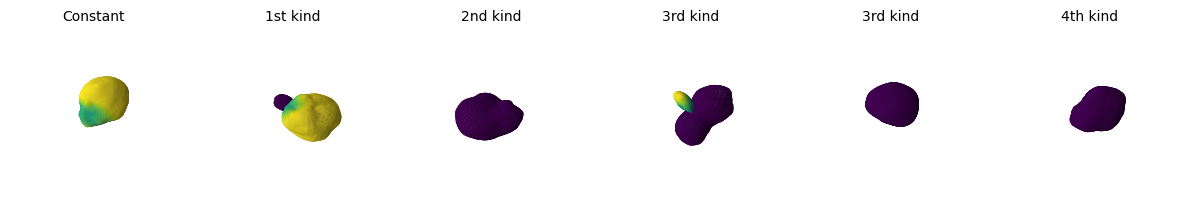

In [58]:
import matplotlib.pyplot as plt

def plot_sphere_surface(ax, X, Y, Z, f, cmap="RdBu", **kwargs):
    cm = plt.get_cmap(cmap)(f.reshape(*X.shape))
    ax.plot_surface(X, Y, Z, facecolors=cm, **kwargs)
    ax.set_xlim([-0.8, 0.8])
    ax.set_ylim([-0.8, 0.8])
    ax.set_zlim([-0.8, 0.8])
    ax.set_axis_off()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_zticklabels([])


fig, axes = plt.subplots(1, 6, figsize=(15, 5), subplot_kw={"projection": "3d"})
j = 0
kinds = ["Constant", "1st kind", "2nd kind", "3rd kind", "3rd kind", "4th kind"]
for i in [0, 1, 7, 9, 15, 19]:
    phi_i = phi[:, i].reshape(*X.shape)
    Dx, Dy, Dz = np.abs(phi_i) * np.stack((X, Y, Z))
    plot_sphere_surface(axes[j], Dx, Dy, Dz, phi_i, alpha=.5, cmap="viridis")
    axes[j].set_title(rf"{kinds[j]}", fontsize=10)
    scale = 2
    axes[j].set_xlim([-scale, scale])
    axes[j].set_ylim([-scale, scale])
    axes[j].set_zlim([-scale, scale])
    j += 1
# fig.savefig("learned_harmonics.jpg", bbox_inches="tight")

In [63]:
num = 5
phi_true, eigenvalues = spherical_harmonic(x_test, num**2, return_eigenvalues=True, real=True)
phi_true /= torch.sqrt(torch.mean(phi_true ** 2, dim=0))
phi_true = phi_true.numpy()

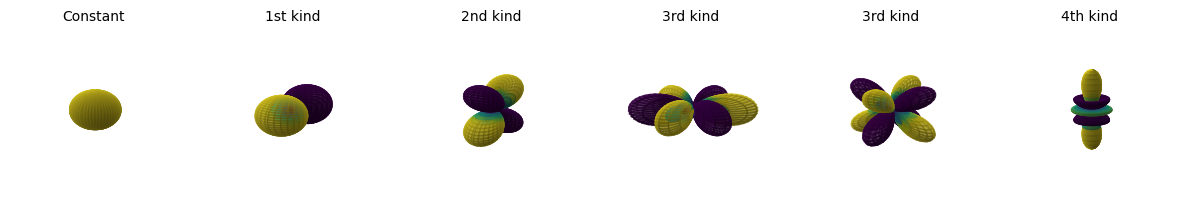

In [64]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5), subplot_kw={"projection": "3d"})
j = 0
for i in [0, 1, 7, 9, 10, 20]:
    phi_i = phi_true[:, i].reshape(*X.shape)
    Dx, Dy, Dz = np.abs(phi_i) * np.stack((X, Y, Z))
    plot_sphere_surface(axes[j], Dx, Dy, Dz, phi_i, alpha=.5, cmap="viridis")
    scale = 2
    axes[j].set_title(f"{kinds[j]}", fontsize=10)
    axes[j].view_init(azim=30, elev=15)
    axes[j].set_xlim([-scale, scale])
    axes[j].set_ylim([-scale, scale])
    axes[j].set_zlim([-scale, scale])
    j += 1